# Accessing and Working With Diffsky Mock Galaxy Catalogs
<div>
<img src="../branding/opencosmo_simple_transparent.png" width="600">
</div>
The `diffsky` mock galaxy catalogs are available on NERSC to anyone with an account. There are two options for accessing the data:

1. Access directly on NERSC via Jupyter or a job script
2. Use the OpenCosmo Compute Portal to query a smaller subset of the data, and move the result to a computing resource of your choice. To request access, fill out [this Google form](https://docs.google.com/forms/d/e/1FAIpQLSdJfDcMnUWPvRXXpOJsGfjUAOMzirG8RpubNO91dQjgZur9Kg/viewform?usp=header)

Feel free to use either (or both!) of these methods. In either case, the data will be stored in the OpenCosmo Format. You can use the [OpenCosmo Python Toolkit](https://opencosmo.readthedocs.io/en/stable/) to access this data and further query it. If working on NERSC, you can find the data at `/global/cfs/cdirs/hacc/OpenCosmo/LastJourney/synthetic_galaxies/`

# Computing Mass Accretion and Star Formation Histories with Diffmah

This notebook demonstrates how to compute mass accretion and star formation histories for a population of synthetic galaxies, with data stored in the OpenCosmo Format.

## Step 0: Install Requirements

In order to run this notebook, you will need to be using an environment with opencosmo, diffmah, and diffstar installed.

You can install opencosmo with:
```
conda create -n diffsky python=3.12 conda-forge::opencosmo
```

Once opencosmo is installed, install the diffsky packages with:

```
conda activate diffsky
opencosmo install diffsky --file /path/to/synthetic/catalog.hdf5
```

If you're working with the original data on NERSC, the dataset will be split into a large number of individual files. You may use any of them for the step above. The file contains information about the versions of Diffmah and Diffstar that were used to produce the catalog. The command above will automatically install the correct versions into your environment, as well as additional dependencies like `jax`.

Additional information about the OpenCosmo toolkit, including additional installation options, can be found on [ReadTheDocs](https://opencosmo.readthedocs.io/en/stable/index.html)


### Step 1: Loading the Data
Now that we have the software we need, we can load the data using the OpenCosmo toolkit. We recommend passing all the files in the catalog to the toolkit. Don't worry, it won't actually read anything yet. We'll restrict to a subset of the data later.

In [25]:
from pathlib import Path
import opencosmo as oc
import numpy as np
import matplotlib.pyplot as plt

In [26]:
# If you are running on your computer, replace the path below with the location of your data
data_path = Path("/Users/patrick/code/Production/OpenCosmo/test_data/diffsky")
# If you are running on NERSC, uncomment the line below
# data_path = Path("/global/cfs/cdirs/hacc/OpenCosmo/LastJourney/synthetic_galaxies/")
files = list(data_path.glob("*.hdf5"))
dataset = oc.open(*files)

### Step 1a (NERSC):
If you are running on NERSC, the data are much too large to access all at once. We can cut it down a bit to make it more manageable. The cell below will select 50,000 galaxies at random between redshift 0.5 and 1.0

In [ ]:
# dataset = dataset.with_redshift_range(0.5, 1.0)
# dataset = dataset.take(50_000)

### Step 1a (Portal):
If you have downloaded data from the portal, there may be too many objects for the diffsky fits to run in a reasonable time. You can select a smaller subset of the data to avoid this issue:

In [31]:
# print(dataset.z_range)
# n_galaxies = len(dataset)
# if n_galaxies > 50_000:
#     dataset = dataset.take(50_000)

The OpenCosmo dataset object does not actually contain any data yet, it just knows how to go get the data when you ask for it. However it does have lots of additional useful information, such as the cosmology of the simulation this catalog was produced from. We can preview the dataset by printing it

In [32]:
dataset

OpenCosmo Lightcone Dataset (length=29136, 0.0 < z < 0.050156739811912265)
Cosmology: FlatLambdaCDM(name=None, H0=<Quantity 67.66 km / (Mpc s)>, Om0=0.3096446816186967, Tcmb0=<Quantity 0. K>, Neff=3.04, m_nu=None, Ob0=0.04897468161869667)
First 10 rows:
central       core_tag      ...       z_nfw          redshift  
                            ...        Mpc                     
 int32         int64        ...      float64         float32   
------- ------------------- ... ------------------ ------------
      1  509188164150114551 ...  79.70049928850653  0.020534992
      1 1454667008967714648 ...  9.665570243589631 0.0024687052
      0  459648568249036396 ...  79.88433402283121   0.02047968
      1  396598173465844601 ...  79.91156492083869   0.02047968
      1 1225260504902040506 ...   82.0099246808491   0.02124989
      1 1198238907137815752 ...  57.68886727410028  0.014870405
      1  959548126887179263 ... 58.534877595554754  0.015161991
      1  716353747009159195 ...  30.592344

## Step 2: Get the Cosmology Information
Diffmah and Diffstar were produced from from halo catlogs from the LastJourney simulation. In order to produce the fits, we need to provide them with information about the cosmology this simulation was run with. We can easily access the astropy Cosmology object for the simulation with the `cosmology` attribute.


In [33]:
cosmology = dataset.cosmology
cosmology

FlatLambdaCDM(name=None, H0=<Quantity 67.66 km / (Mpc s)>, Om0=0.3096446816186967, Tcmb0=<Quantity 0. K>, Neff=3.04, m_nu=None, Ob0=0.04897468161869667)

## Step 3: Retrive the parameters for the Mass Accretion History fits

To compute the mass accretion histories, we need to retrieve the relavent columns from the catalog. By selecting these columns with `dataset.select`, we ensure OpenCosmo doesn't try to load a ton of unnecessary data into memory. 

In [34]:
from diffmah import DEFAULT_MAH_PARAMS
# Get the names of the relevant columns
diffmah_columns = [key for key in DEFAULT_MAH_PARAMS._fields]
# Getting the data for those columns as numpy arrays 
diffmah_data = dataset.select(diffmah_columns).get_data("numpy")
# Convert to the format Diffmah expects
diffmah_data = [diffmah_data[key] for key in diffmah_columns]
mah_params = DEFAULT_MAH_PARAMS._make(diffmah_data)

## Step 4: Compute Mass Accretion Histories and make a plot

Text(0, 0.5, 'Maximum Halo Mass   $log(M_{halo}/M_{sun})$')

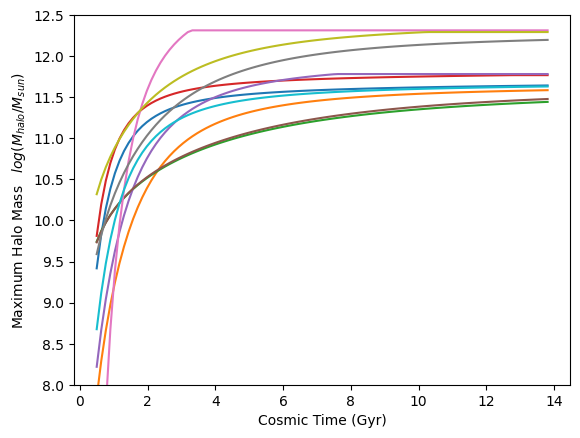

In [35]:
from diffmah import mah_halopop

t0 = cosmology.age(0).value
tarr = np.linspace(0.5, t0, 100)

dmdht, log_mah = mah_halopop(mah_params, tarr, np.log10(t0))

fig, ax = plt.subplots(1, 1)

for i in range(10):
    __=ax.plot(tarr, log_mah[i, :])

_ = ax.set_ylim(8,12.5)
ax.set_xlabel("Cosmic Time (Gyr)")
ax.set_ylabel(r"Maximum Halo Mass   $log(M_{halo}/M_{sun})$")

## Step 5: Repeat Step 2 for Star Formation History Parameters


In [36]:
from diffstar import DEFAULT_DIFFSTAR_PARAMS
sfh_columns = DEFAULT_DIFFSTAR_PARAMS.ms_params._fields +  DEFAULT_DIFFSTAR_PARAMS.q_params._fields
diffstar_data = dataset.select(sfh_columns).data

sfh_ms_data = [diffstar_data[key].value for key in DEFAULT_DIFFSTAR_PARAMS.ms_params._fields]
sfh_q_data = [diffstar_data[key].value for key in DEFAULT_DIFFSTAR_PARAMS.q_params._fields]

sfh_ms_params = DEFAULT_DIFFSTAR_PARAMS.ms_params._make(sfh_ms_data)
sfh_q_params = DEFAULT_DIFFSTAR_PARAMS.q_params._make(sfh_q_data)

sfh_params = DEFAULT_DIFFSTAR_PARAMS._make((sfh_ms_params, sfh_q_params))

## Step 6: Compute SFH and make a plot

(0.001, 100.0)

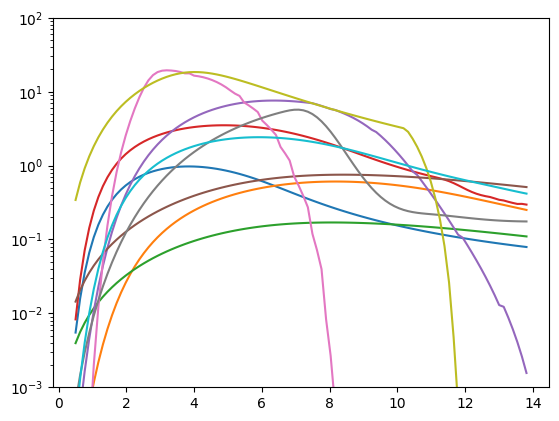

In [37]:
from diffstar import calc_sfh_galpop
fb_last_journey = cosmology.Ob0 / cosmology.Om0

sfh, smh = calc_sfh_galpop(sfh_params, mah_params, tarr, lgt0=np.log10(t0), fb=fb_last_journey, return_smh=True)

fig, ax = plt.subplots(1, 1)
yscale = ax.set_yscale('log')
yscale = ax.set_ylim(1e-5, 200)

for i in range(10):
    __=ax.plot(tarr, sfh[i, :])

ax.set_ylim(1e-3, 1e2)